In [1]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from plotnine import *
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, svm, tree
from scipy import stats

# for linear regression 
from sklearn import linear_model
from scipy import stats

In [2]:
arms_sales = pd.read_csv('TIV-Import-All-1950-2020.csv')

# Filling all the NaN values with 0.0 for later calculation
arms_sales.fillna(value=0, inplace=True)
arms_sales_original = arms_sales
arms_sales.head()

,Country,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,4.0,7.0,89.0,254.0,...,523.0,235.0,288.0,116.0,174.0,252.0,349.0,382.0,227.0,16391.0
1,African Union**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,79.0
2,Albania,20.0,10.0,11.0,20.0,22.0,132.0,98.0,42.0,47.0,...,15.0,7.0,7.0,7.0,0.0,4.0,2.0,5.0,0.0,2771.0
3,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,661.0,362.0,620.0,898.0,2903.0,1128.0,1284.0,164.0,549.0,32139.0
4,Amal (Lebanon)*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0


In [3]:
#================================================
#============= Moving Data Around ===============
#================================================

# Sorting the values by the 'Total' of the row to find the highest values in the data.

arms_sales.sort_values(by=['Total'], ascending=False, inplace=True)

In [4]:
# Rearranging values, bringing 'Total' to the first column in the df.

cols = arms_sales.columns.tolist()
cols = cols[-1:] + cols[:-1]
# cols

arms_sales = arms_sales[cols] 
arms_sales.head()

,Total,Country,1950,1951,1952,1953,1954,1955,1956,1957,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
260,1973386.0,Total,8139.0,11497.0,16533.0,24027.0,20371.0,20147.0,24262.0,23556.0,...,30043.0,27995.0,27174.0,27073.0,28638.0,31438.0,31762.0,27028.0,27105.0,22831.0
94,126727.0,India,141.0,277.0,104.0,430.0,265.0,350.0,366.0,980.0,...,3598.0,4392.0,5381.0,3347.0,3117.0,3003.0,2909.0,1485.0,3075.0,2799.0
39,80828.0,China,2572.0,2197.0,3430.0,3144.0,3500.0,1730.0,2255.0,2126.0,...,1055.0,1571.0,1289.0,1077.0,1262.0,1139.0,1338.0,1962.0,1347.0,811.0
193,70781.0,Saudi Arabia,0.0,0.0,7.0,1.0,2.0,16.0,10.0,72.0,...,1222.0,1033.0,1614.0,2740.0,3377.0,2961.0,3931.0,3315.0,3419.0,2466.0
58,67745.0,Egypt,163.0,57.0,0.0,1.0,142.0,725.0,1065.0,479.0,...,630.0,281.0,673.0,420.0,1436.0,1690.0,2395.0,1677.0,1046.0,1311.0


In [6]:
# Dropping row that is the total of all values. Not useful for the analysis. This part is optional.

arms_sales = arms_sales.drop(labels=[260], axis=0)
arms_sales.head()

,Total,Country,1950,1951,1952,1953,1954,1955,1956,1957,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
94,126727.0,India,141.0,277.0,104.0,430.0,265.0,350.0,366.0,980.0,...,3598.0,4392.0,5381.0,3347.0,3117.0,3003.0,2909.0,1485.0,3075.0,2799.0
39,80828.0,China,2572.0,2197.0,3430.0,3144.0,3500.0,1730.0,2255.0,2126.0,...,1055.0,1571.0,1289.0,1077.0,1262.0,1139.0,1338.0,1962.0,1347.0,811.0
193,70781.0,Saudi Arabia,0.0,0.0,7.0,1.0,2.0,16.0,10.0,72.0,...,1222.0,1033.0,1614.0,2740.0,3377.0,2961.0,3931.0,3315.0,3419.0,2466.0
58,67745.0,Egypt,163.0,57.0,0.0,1.0,142.0,725.0,1065.0,479.0,...,630.0,281.0,673.0,420.0,1436.0,1690.0,2395.0,1677.0,1046.0,1311.0
103,65890.0,Japan,0.0,0.0,8.0,223.0,314.0,408.0,757.0,1059.0,...,268.0,205.0,252.0,307.0,329.0,330.0,441.0,654.0,899.0,724.0


In [7]:
# years = arms_sales.iloc[1:4, 2:].columns.tolist()
# countries = arms_sales['Country'].tolist()
# years[0:11]
# years[11:21]
# years[21:31]
# years[31:41]
# years[41:51]
# years[51:61]
# years[61:71]
# years[71:81]

# arms_sales[['Country','1950','1951','1952','1953','1954','1955','1956','1957','1958', '1959']]
# arms_sales[['Country','1960','1961','1962','1962','1962','1962','1962','1962','1962', '1962']]
# df_1950_1960 = arms_sales[['Country','1950','1951','1952','1953','1954','1955','1956','1957','1958', '1959']].copy(deep=True)
# df_1960_1970 = small_arms_df.loc[filt_1960_1970].copy(deep=True)
# df_1970_1980 = small_arms_df.loc[filt_1970_1980].copy(deep=True)
# df_1980_1990 = small_arms_df.loc[filt_1980_1990].copy(deep=True)
# df_1990_2000 = small_arms_df.loc[filt_1990_2000].copy(deep=True)
# df_2000_2010 = small_arms_df.loc[filt_2000_2010].copy(deep=True)
# df_2010_2020 = small_arms_df.loc[filt_2010_2020].copy(deep=True)

In [8]:
#================================================
#============= Restructuring Data ===============
#================================================

# Reshaping the data just like project 3 for easier calculations and familiarity.

# Putting all years and countries into separate lists
years = arms_sales.iloc[1:4, 2:].columns.tolist()
countries = arms_sales['Country'].tolist()

# Initializing empty arrays to append data
country_list = []
year_list = []
import_list = []
totals_list = []
year_mean_list = []

# Double for-loop through all countries and years
for country in countries:
    for year in years:
        # Appending values
        country_list.append(country)
        year_list.append(year)

        # Index of row where Country = Country (ex: Country == 'China') which will be used to locate value.
        country_index = arms_sales.index[arms_sales['Country'] == country][0]
        import_value = arms_sales.at[country_index, year]
        total_value = arms_sales.at[country_index, 'Total']
        year_mean = arms_sales[year].mean()

        # Appending retrieved values and calculations
        import_list.append(import_value)
        totals_list.append(total_value)
        year_mean_list.append(year_mean)


# N_O_T_E: Entire average over top 50 can be accessed through this quick calculation:
total_mean_over_top_50 = arms_sales['Total'].mean()

# Structuring data
data = {
    'country': country_list,
    'year': year_list,
    'imports': import_list,
    'year_avg_imports': year_mean_list,
    'total_imports_for_country': totals_list
    }


# Placing data into pandas dataframe. N_O_T_E: Remember you can always access the original because it still exists (i.e. arms_sales). There is also the most original reference stored in arms_sales_original, which has all the intial data in addition to the top 50. 
small_arms_df = pd.DataFrame(data)

small_arms_df

,country,year,imports,year_avg_imports,total_imports_for_country
0,India,1950,141.0,35.050000,126727.0
1,India,1951,277.0,47.963462,126727.0
2,India,1952,104.0,67.338462,126727.0
3,India,1953,430.0,96.186538,126727.0
4,India,1954,265.0,82.134615,126727.0
...,...,...,...,...,...
36915,Zimbabwe,2016,0.0,124.815385,946.0
36916,Zimbabwe,2017,0.0,126.048077,946.0
36917,Zimbabwe,2018,0.0,107.850000,946.0
36918,Zimbabwe,2019,0.0,108.140385,946.0


In [9]:
# small_arms_df['year'] = small_arms_df['year'].astype(str)
# filt = (small_arms_df['country'] == "India") & (small_arms_df['year'] == "1950")
# filt = small_arms_df['cut_year'] == "1950-1960"
# small_arms_df[filt].sort_values(by=['imports'], ascending=False)

In [10]:
#================================================
#====== Creating Bins for slicing years =========
#================================================

# Approach like from project2, cutting the data up and displaying from there. 

small_arms_df['year'] = small_arms_df['year'].astype(int)

bins = [1949, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
groups = ["1950-1960", "1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2020"]

# Created new column that depicts which range in years a row falls into.
small_arms_df['cut_year'] = pd.cut(small_arms_df.year, bins, labels=groups)

small_arms_df

,country,year,imports,year_avg_imports,total_imports_for_country,cut_year
0,India,1950,141.0,35.050000,126727.0,1950-1960
1,India,1951,277.0,47.963462,126727.0,1950-1960
2,India,1952,104.0,67.338462,126727.0,1950-1960
3,India,1953,430.0,96.186538,126727.0,1950-1960
4,India,1954,265.0,82.134615,126727.0,1950-1960
...,...,...,...,...,...,...
36915,Zimbabwe,2016,0.0,124.815385,946.0,2010-2020
36916,Zimbabwe,2017,0.0,126.048077,946.0,2010-2020
36917,Zimbabwe,2018,0.0,107.850000,946.0,2010-2020
36918,Zimbabwe,2019,0.0,108.140385,946.0,2010-2020


In [12]:
#================================================
#========= Creating Separate Dataframes =========
#================================================


# Filtering out data and creating deep copies of each dataframe for later analysis in 10 year intervals

# filt_1950_1960 = small_arms_df['cut_year'] == "1950-1960"
# filt_1960_1970 = small_arms_df['cut_year'] == "1960-1970"
# filt_1970_1980 = small_arms_df['cut_year'] == "1970-1980"
# filt_1980_1990 = small_arms_df['cut_year'] == "1980-1990"
# filt_1990_2000 = small_arms_df['cut_year'] == "1990-2000"
# filt_2000_2010 = small_arms_df['cut_year'] == "2000-2010"
# filt_2010_2020 = small_arms_df['cut_year'] == "2010-2020"

# df_1950_1960 = small_arms_df.loc[filt_1950_1960].copy(deep=True)
# df_1960_1970 = small_arms_df.loc[filt_1960_1970].copy(deep=True)
# df_1970_1980 = small_arms_df.loc[filt_1970_1980].copy(deep=True)
# df_1980_1990 = small_arms_df.loc[filt_1980_1990].copy(deep=True)
# df_1990_2000 = small_arms_df.loc[filt_1990_2000].copy(deep=True)
# df_2000_2010 = small_arms_df.loc[filt_2000_2010].copy(deep=True)
# df_2010_2020 = small_arms_df.loc[filt_2010_2020].copy(deep=True)

df_1950_1960 = arms_sales[["Country",'1950','1951','1952','1953','1954','1955','1956','1957','1958', '1959']].copy(deep=True)
df_1950_1960["sum"] = df_1950_1960.sum(axis=1)
df_1960_1970 = arms_sales[["Country",'1960','1961','1962','1963','1964','1965','1966','1967','1968', '1969']].copy(deep=True)
df_1960_1970["sum"] = df_1960_1970.sum(axis=1)
df_1970_1980 = arms_sales[["Country",'1970','1971','1972','1973','1974','1975','1976','1977','1978', '1979']].copy(deep=True)
df_1970_1980["sum"] = df_1970_1980.sum(axis=1)
df_1980_1990 = arms_sales[["Country",'1980','1981','1982','1983','1984','1985','1986','1987','1988', '1989']].copy(deep=True)
df_1980_1990["sum"] = df_1980_1990.sum(axis=1)
df_1990_2000 = arms_sales[["Country",'1990','1991','1992','1993','1994','1995','1996','1997','1998', '1999']].copy(deep=True)
df_1990_2000["sum"] = df_1990_2000.sum(axis=1)
df_2000_2010 = arms_sales[["Country",'2000','2001','2002','2003','2004','2005','2006','2007','2008', '2009']].copy(deep=True)
df_2000_2010["sum"] = df_2000_2010.sum(axis=1)
df_2010_2020 = arms_sales[["Country",'2010','2011','2012','2013','2014','2015','2016','2017','2018', '2019','2020']].copy(deep=True)
df_2010_2020["sum"] = df_2010_2020.sum(axis=1)

# df_1950_1960.sort_values(by=['imports'], ascending=False, inplace=True)
# df_1960_1970.sort_values(by=['imports'], ascending=False, inplace=True)
# df_1970_1980.sort_values(by=['imports'], ascending=False, inplace=True)
# df_1980_1990.sort_values(by=['imports'], ascending=False, inplace=True)
# df_1990_2000.sort_values(by=['imports'], ascending=False, inplace=True)
# df_2000_2010.sort_values(by=['imports'], ascending=False, inplace=True)
# df_2010_2020.sort_values(by=['imports'], ascending=False, inplace=True)

df_1950_1960.reset_index(drop=True, inplace=True)
df_1960_1970.reset_index(drop=True, inplace=True)
df_1970_1980.reset_index(drop=True, inplace=True)
df_1980_1990.reset_index(drop=True, inplace=True)
df_1990_2000.reset_index(drop=True, inplace=True)
df_2000_2010.reset_index(drop=True, inplace=True)
df_2010_2020.reset_index(drop=True, inplace=True)

# top_10_1950_1960 = df_1950_1960.head(10).copy(deep=True)
# top_10_1960_1970 = df_1960_1970.head(10).copy(deep=True)
# top_10_1970_1980 = df_1970_1980.head(10).copy(deep=True)
# top_10_1980_1990 = df_1980_1990.head(10).copy(deep=True)
# top_10_1990_2000 = df_1990_2000.head(10).copy(deep=True)
# top_10_2000_2010 = df_2000_2010.head(10).copy(deep=True)
# top_10_2010_2020 = df_2010_2020.head(10).copy(deep=True)

top_50_1950_1960 = df_1950_1960.head(50).copy(deep=True)
top_50_1960_1970 = df_1960_1970.head(50).copy(deep=True)
top_50_1970_1980 = df_1970_1980.head(50).copy(deep=True)
top_50_1980_1990 = df_1980_1990.head(50).copy(deep=True)
top_50_1990_2000 = df_1990_2000.head(50).copy(deep=True)
top_50_2000_2010 = df_2000_2010.head(50).copy(deep=True)
top_50_2010_2020 = df_2010_2020.head(50).copy(deep=True)

,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,sum
94,India,2911.0,3598.0,4392.0,5381.0,3347.0,3117.0,3003.0,2909.0,1485.0,3075.0,2799.0,36017.0
39,China,981.0,1055.0,1571.0,1289.0,1077.0,1262.0,1139.0,1338.0,1962.0,1347.0,811.0,13832.0
193,Saudi Arabia,1083.0,1222.0,1033.0,1614.0,2740.0,3377.0,2961.0,3931.0,3315.0,3419.0,2466.0,27161.0
58,Egypt,686.0,630.0,281.0,673.0,420.0,1436.0,1690.0,2395.0,1677.0,1046.0,1311.0,12245.0
103,Japan,403.0,268.0,205.0,252.0,307.0,329.0,330.0,441.0,654.0,899.0,724.0,4812.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Guinea,4.0,1.0,4.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,17.0
345,Guinea-Bissau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,GUNT (Chad)*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,Guyana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0


In [10]:
def fit_regression_model(data_frame):
    years = np.array(data_frame['year'])
    imports = np.array(data_frame['imports'])
    LR = LinearRegression()
    LR.fit(years.reshape(-1,1), imports)
    prediction = LR.predict(years.reshape(-1,1))
    data_frame['importsPredict'] = pd.Series(prediction, index=data_frame.index)
    data_frame['residual'] = data_frame['imports'] - data_frame['importsPredict']

    # RM = Regression Model
    RM = ols(formula='year ~ year_avg_imports', data=data_frame).fit() 
    return RM

In [11]:
#================================================
#================================================
# Individual plots and fitting regression models 
#================================================
#================================================

#================================================
#================= 1950-1960 ====================
#================================================


# N_O_T_E: Same calculations from project3. I used the year_average as the dependant variable here, I was likely wrong, so please let me know your opinion. Honestly not good at this. The only relationship I know these variables have is that the number of imports will increase depending on the year (wartime). Don't we need some kind of expected values for fitting a model?

# N_O_T_E: Needed to use top 50 because 'N' needed to be greater than 20. 
top_50_1950_1960['year'] = top_50_1950_1960['year'].astype(int)

# Calling regression model function to get the coefficient. Please refer to the function to tweak in a way that works best for you. If correct, the coefficient should be the table like you asked. 
fit_regression_model(top_50_1950_1960).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     16.04
Date:                Sun, 16 May 2021   Prob (F-statistic):           0.000215
Time:                        15:44:02   Log-Likelihood:                -117.30
No. Observations:                  50   AIC:                             238.6
Df Residuals:                      48   BIC:                             242.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1948.6546      1.675   1163.620      0.000    1945.287    1952.022
year_avg_imports     0.0796      0.020      4.005      0.000       0.040       0.120
==============================================================================
Omnibus:                        7.550   Durbin-Watson:                   1.123
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.097
Skew:                           0.916   Prob(JB):                       0.0288
Kurtosis:                       3.222   Cond. No.                         387.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\Josh\anaconda3\lib\site-packages\plotnine\stats\stat_smooth.py:197: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


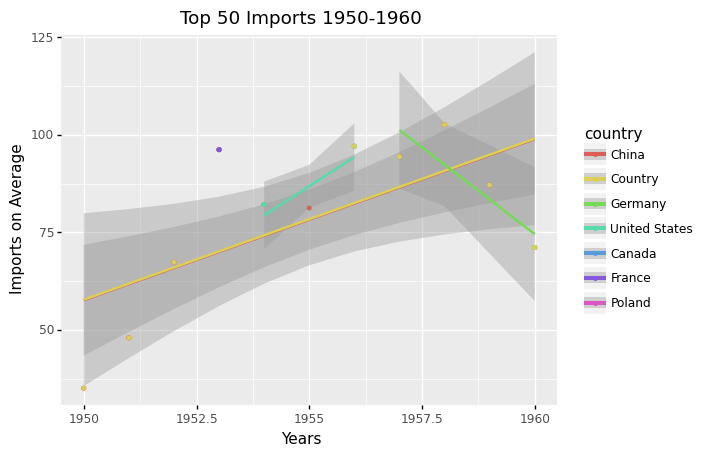

<ggplot: (152477838460)>

In [12]:
#================================================
#=============== EXAMPLE PLOT!!! ================
#================================================

# This is just an example of what you may have been asking for. If you show me a picture of what you'd like, I will try my best to replicate it. 

top_50_1950_1960['year'] = top_50_1950_1960['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports', color='country'), data=top_50_1950_1960) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 1950-1960",
         x = "Years",
         y = "Imports on Average")

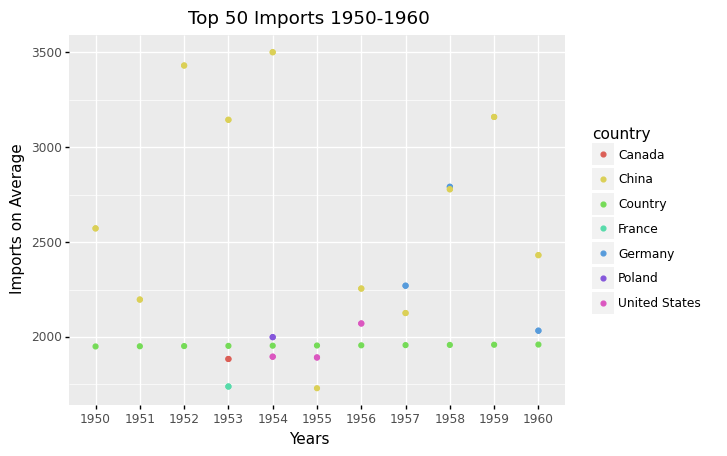

<ggplot: (152480881999)>

In [32]:
top_50_1950_1960['year'] = top_50_1950_1960['year'].astype(str)

ggplot(aes(x='year', y='imports'), data=top_50_1950_1960) + geom_point(aes(color='country')) +\
    labs(title="Top 50 Imports 1950-1960",
         x = "Years",
         y = "Imports on Average")

In [14]:
#================================================
#================= 1960-1970 ====================
#================================================

top_50_1960_1970['year'] = top_50_1960_1970['year'].astype(int)
fit_regression_model(top_50_1960_1970).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     84.34
Date:                Sun, 16 May 2021   Prob (F-statistic):           3.82e-12
Time:                        15:44:04   Log-Likelihood:                -97.455
No. Observations:                  50   AIC:                             198.9
Df Residuals:                      48   BIC:                             202.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1950.3313      1.709   1141.454      0.000    1946.896    1953.767
year_avg_imports     0.1597      0.017      9.183      0.000       0.125       0.195
==============================================================================
Omnibus:                        0.955   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.329
Skew:                          -0.108   Prob(JB):                        0.848
Kurtosis:                       3.333   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

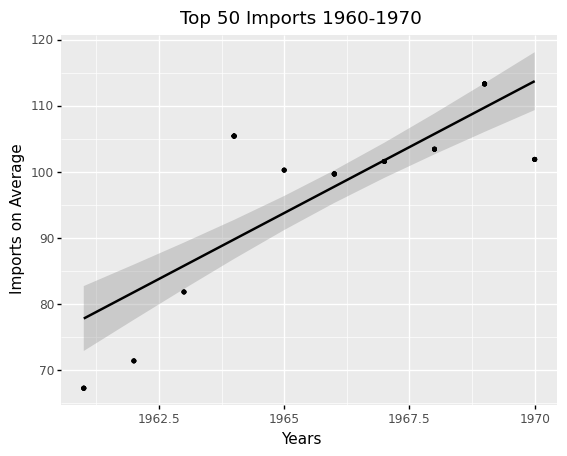

<ggplot: (152479741392)>

In [15]:
top_50_1960_1970['year'] = top_50_1960_1970['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_1960_1970) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 1960-1970",
         x = "Years",
         y = "Imports on Average")

In [16]:
#================================================
#================= 1970-1980 ====================
#================================================

top_50_1970_1980['year'] = top_50_1970_1980['year'].astype(int)
fit_regression_model(top_50_1970_1980).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sun, 16 May 2021   Prob (F-statistic):           6.26e-16
Time:                        15:44:05   Log-Likelihood:                -88.853
No. Observations:                  50   AIC:                             181.7
Df Residuals:                      48   BIC:                             185.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1943.7275      2.681    725.124      0.000    1938.338    1949.117
year_avg_imports     0.2142      0.018     11.903      0.000       0.178       0.250
==============================================================================
Omnibus:                       10.751   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.448
Skew:                           1.168   Prob(JB):                      0.00327
Kurtosis:                       3.185   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

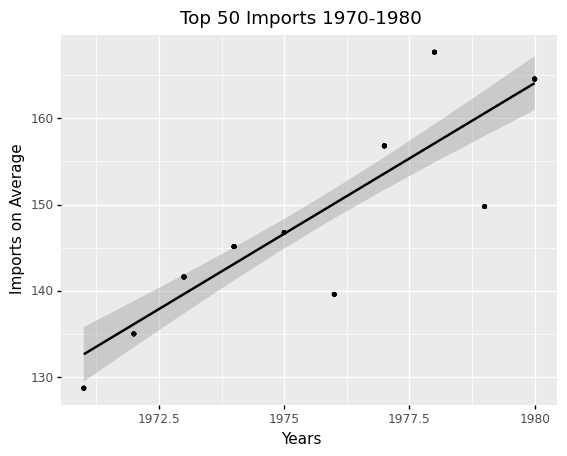

<ggplot: (152479422838)>

In [17]:
top_50_1970_1980['year'] = top_50_1970_1980['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_1970_1980) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 1970-1980",
         x = "Years",
         y = "Imports on Average")

In [18]:
#================================================
#================= 1980-1990 ====================
#================================================

top_50_1980_1990['year'] = top_50_1980_1990['year'].astype(int)
fit_regression_model(top_50_1980_1990).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     611.9
Date:                Sun, 16 May 2021   Prob (F-statistic):           5.73e-29
Time:                        15:44:06   Log-Likelihood:                -58.508
No. Observations:                  50   AIC:                             121.0
Df Residuals:                      48   BIC:                             124.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2009.7110      1.004   2002.274      0.000    2007.693    2011.729
year_avg_imports    -0.1549      0.006    -24.736      0.000      -0.168      -0.142
==============================================================================
Omnibus:                        1.849   Durbin-Watson:                   0.781
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                1.396
Skew:                          -0.200   Prob(JB):                        0.498
Kurtosis:                       2.286   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

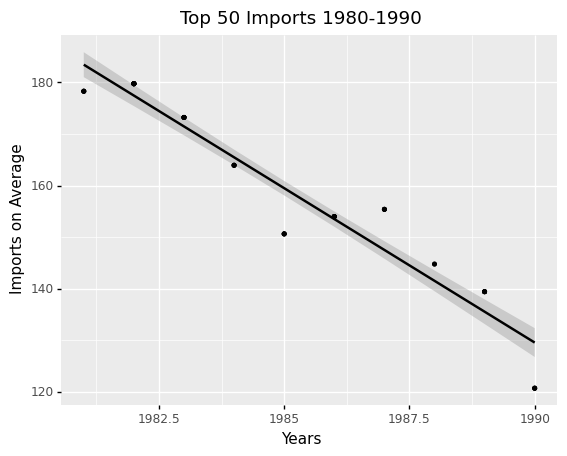

<ggplot: (152477892943)>

In [19]:
top_50_1980_1990['year'] = top_50_1980_1990['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_1980_1990) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 1980-1990",
         x = "Years",
         y = "Imports on Average")

In [20]:
#================================================
#================= 1990-2000 ====================
#================================================

top_50_1990_2000['year'] = top_50_1990_2000['year'].astype(int)
fit_regression_model(top_50_1990_2000).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6679
Date:                Sun, 16 May 2021   Prob (F-statistic):              0.418
Time:                        15:44:07   Log-Likelihood:                -123.53
No. Observations:                  50   AIC:                             251.1
Df Residuals:                      48   BIC:                             254.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1998.7177      4.349    459.627      0.000    1989.974    2007.461
year_avg_imports    -0.0348      0.043     -0.817      0.418      -0.121       0.051
==============================================================================
Omnibus:                       72.935   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.436
Skew:                           0.106   Prob(JB):                       0.0660
Kurtosis:                       1.398   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

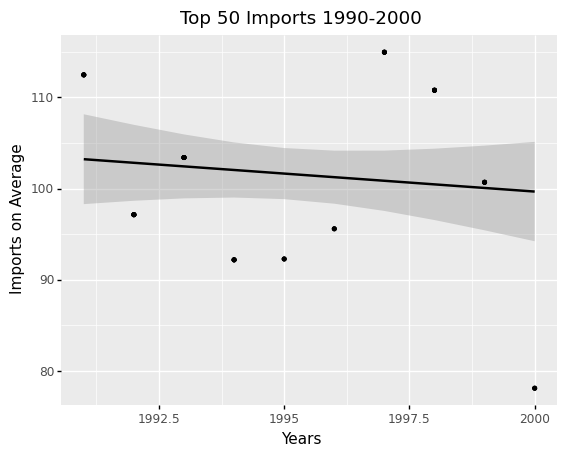

<ggplot: (152479671751)>

In [21]:
top_50_1990_2000['year'] = top_50_1990_2000['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_1990_2000) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 1990-2000",
         x = "Years",
         y = "Imports on Average")

In [22]:
#================================================
#================= 2000-2010 ====================
#================================================

top_50_2000_2010['year'] = top_50_2000_2010['year'].astype(int)
fit_regression_model(top_50_2000_2010).summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     176.1
Date:                Sun, 16 May 2021   Prob (F-statistic):           1.12e-17
Time:                        15:44:08   Log-Likelihood:                -82.089
No. Observations:                  50   AIC:                             168.2
Df Residuals:                      48   BIC:                             172.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1987.1097      1.398   1421.825      0.000    1984.300    1989.920
year_avg_imports     0.2034      0.015     13.270      0.000       0.173       0.234
==============================================================================
Omnibus:                        7.268   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                2.652
Skew:                           0.185   Prob(JB):                        0.266
Kurtosis:                       1.934   Cond. No.                         707.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

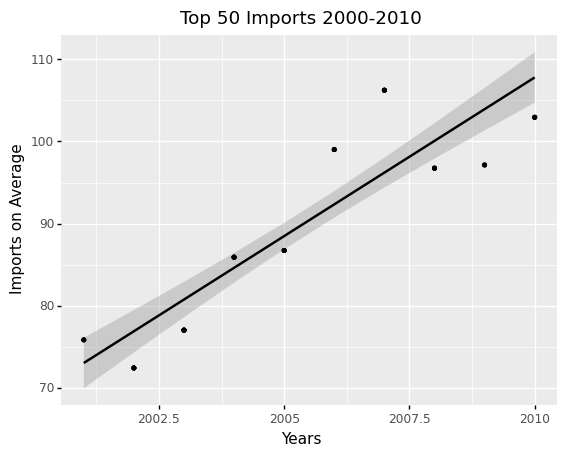

<ggplot: (152479658990)>

In [23]:
top_50_2000_2010['year'] = top_50_2000_2010['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_2000_2010) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 2000-2010",
         x = "Years",
         y = "Imports on Average")

In [24]:
#================================================
#================= 2010-2020 ====================
#================================================

top_50_2010_2020['year'] = top_50_2010_2020['year'].astype(int)
fit_regression_model(top_50_2010_2020).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.654
Date:                Sun, 16 May 2021   Prob (F-statistic):             0.0214
Time:                        15:44:08   Log-Likelihood:                -117.15
No. Observations:                  50   AIC:                             238.3
Df Residuals:                      48   BIC:                             242.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2025.6515      4.100    494.023      0.000    2017.407    2033.896
year_avg_imports    -0.0861      0.036     -2.378      0.021      -0.159      -0.013
==============================================================================
Omnibus:                       23.899   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.027
Skew:                          -0.519   Prob(JB):                       0.0491
Kurtosis:                       1.653   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

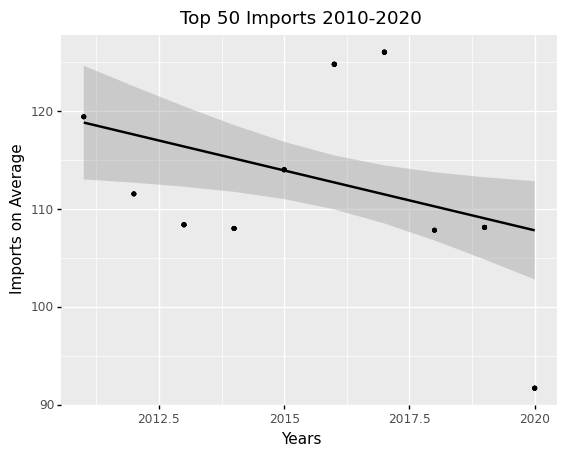

<ggplot: (152479450579)>

In [25]:
top_50_2010_2020['year'] = top_50_2010_2020['year'].astype(int)

ggplot(aes(x='year', y='year_avg_imports'), data=top_50_2010_2020) + stat_smooth(method="lm") + geom_point(size=1) +\
    labs(title="Top 50 Imports 2010-2020",
         x = "Years",
         y = "Imports on Average")